In [1]:
import re
import functools
import operator
import itertools
import collections

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

reduce = functools.reduce

Part = collections.namedtuple('Part', ['x', 'm', 'a', 's'])

In [2]:
def read_input(filename):
    lines = []
    with open(filename) as f:
        for line in f:
            if len(line.strip()) == 0:
                yield lines
                lines = []
            else:
                lines.append(line.strip())
        yield lines

In [3]:
# raw_workflows, raw_parts = read_input("../input/day19-sample1.txt")
raw_workflows, raw_parts = read_input("../input/day19-input.txt")

In [4]:
def parse_part(p):
    return Part(*map(int, re.findall(r"\d+", p)))


In [5]:
def true(a, b):
    return True

operators = {
    '<': operator.lt,
    '>': operator.gt,
    '.': true
}

def parse_workflow(workflow):
    name, raw_rules = re.match("([a-z]+)\{(.+)\}", workflow).groups()
    rules = []
    for rule in raw_rules.split(","):
        if ":" in rule:
            condition, target = rule.split(":")
            var, op, raw_val = re.match("([xmas])([<>])(\d+)", condition).groups()
            val = int(raw_val)
        else:
            var = 'x'
            op = '.'
            val = 0
            target = rule
        rules.append(((op, var, val), target))
    return name, rules

In [6]:
parts = [parse_part(p) for p in raw_parts]
workflows = dict(parse_workflow(w) for w in raw_workflows)

In [7]:
def run_workflow(part, workflow):
    # print(part, workflow)
    # print("---")
    for rule in workflow:
        # print(rule)
        (op, var, val), target = rule
        f = operators[op]
        if f(getattr(part, var), val):
            return target

In [8]:
def sort_part(part, workflows, debug=False):
    label = 'in'
    path = []
    while label not in ['A', 'R']:
        path.append(label)
        w = workflows[label]
        label = run_workflow(part, w)
    if debug:
        path.append(label)
        print("sort_part", part, path)
    return label

def sort_parts(parts, workflows):
    A = []
    R = []
    for part in parts:
        target = sort_part(part, workflows)
        if target == 'A':
            A.append(part)
        else:
            R.append(part)
    return A, R

In [9]:
X = zip(*[sort_part(p, workflows) for p in parts])
# print(list(X))

In [10]:
def sum_part(p):
    return p.x + p.m + p.a + p.s

In [11]:
part1 = sum(
    sum_part(p)
    for p in parts
    if sort_part(p, workflows) == 'A'
)
part1

382440

In [12]:
def scan(f, init, arr):
    yield init
    acc = init
    for x in arr:
        acc = f(acc, x)
        yield acc

In [13]:
# [workflows['in'][:i + 1] for i in range(len(workflows['in']))]

In [14]:
# fuck it, it's lisp time!

workflow_rules = dict()

for label, workflow in workflows.items():
    workflow_rules[label] = dict()
    ruleset = zip(
        [w[1] for w in workflow], 
        (
            [
                list(w[0])
                for w in workflow[:1]
            ] +
            [
                ['and', *(
                     [
                         ['not', list(w[0])]
                         for w in workflow[:i]
                     ] +
                     [
                         list(w[0])
                         for w in [workflow[i]]
                     ]
                )]
                for i in range(1, len(workflow))
            ]
        )
    )
    rules = dict()
    for target, rule in ruleset:
        if target not in rules:
            rules[target] = []
        rules[target].append(rule)
    
    for target, target_rules in rules.items():
        if len(target_rules) > 1:
            workflow_rules[label][target] = ['or', *target_rules]
        else:
            workflow_rules[label][target] = target_rules[0]
    
# workflow_rules

In [15]:
# graph between workflows
G = nx.DiGraph()
G.add_nodes_from(workflows.keys())
G.add_node('A')
G.add_node('R')

In [16]:
G.add_edges_from([
    (k, tar)
    for k, v in workflows.items()
    for _, tar in v
])

In [17]:
# len(G)

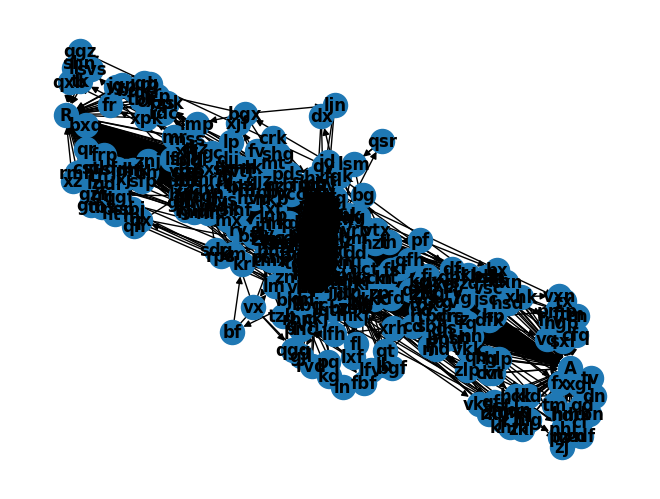

In [18]:
nx.draw(G, pos=nx.spring_layout(G, k=0.1), with_labels=True, font_weight='bold')

In [19]:
path_rules = []
for path in nx.all_simple_paths(G, source='in', target='A'):
    path_rules.append(['and', *list(workflow_rules[a][b] for a, b in itertools.pairwise(path))])

giant_lispy_rule = ['or', *path_rules]

# giant_lispy_rule

In [20]:
# aside: logic on lists of intervals


# def reduce2(f, iterable):
#     it = iter(iterable)
#     value = [next(it)]
#     for element in it:
#         value = [vv for v in value for vv in f(v, element)]
#     return value

# def overlap(a, b):
#     return a[1] >= b[0] and b[1] >= b[0]


# def subinterval(a, b):
#     return a[0] >= b[0] and a[1] <= b[1]


# def filter_empty(aa):
#     return [a for a in aa if a[0] < a[1]]


# def merge2(aa, bb):
#     result = sorted(aa + bb)
#     changed = True
    
#     result = filter_empty(result)
    
#     while changed:
#         changed = False
#         new_result = set()
        
#         for a, b in itertools.pairwise(result):
#             if overlap(a, b):
#                 new_result.add((min(a[0], b[0]), max(a[1], b[1])))
#                 changed = True
#             else:
#                 new_result.add(a)
#                 new_result.add(b)
#         if changed:
#             result = sorted(new_result)
#     return result


# def merge_many(intvs):
#     return reduce(merge2, intvs)


# def intersect2(aa, bb):
#     result = []
#     for (a, b) in itertools.product(aa, bb):
#         if overlap(a, b):
#             result.append((max(a[0], b[0]), min([a[1], b[1]])))
#     return sorted(result)


# def intersect_many(intvs):
#     return reduce(intersect2, intvs)


# def complement1(aa):
#     if len(aa) == 0:
#         return [(0, 10000)]
#     else:
#         result = []
#         if aa[0][0] > 0:
#             result.append((0, aa[0][0] - 1))
#         for a,b in itertools.pairwise(aa):
#             result.append((a[1] + 1, b[0] - 1))
#         if aa[-1][1] < 10000:
#             result.append((aa[-1][1] + 1, 10000))
#         return result


# def complement_many(intvs):
#     xx = list(intvs)
#     return merge_many(complement1(a) for a in xx)



In [21]:
# functions i need to implement:
# - or
# - and
# - not
# - <
# - >
# - . (true)

# need to work on lists of intervals for 'or' and 'not' to work
symbols = {
    'x': (1, 4000),
    'm': (1, 4000),
    'a': (1, 4000),
    's': (1, 4000)
}



def eval_expr(expr):
    # print("eval", expr)
    fn = expr[0]
    args = expr[1:]
    if not isinstance(fn, str): # already evaluated xmas table
        return args
    elif fn == '<':
        return fn_lt(args, symbols)
    elif fn == '>':
        return fn_gt(args, symbols)
    elif fn == '.':
        return fn_true(args, symbols)
    elif fn == 'and':
        return fn_and(args)
    elif fn == 'or':
        return fn_or(args)
    elif fn == 'not':
        return fn_not(args)
    else:
        raise Exception('invalid function call', expr)


def intersect2i(a, b):
    return (max(a[0], b[0]), min([a[1], b[1]]))



# always expr = [symbol, val]
def fn_lt(expr, symbols):
    symbol, val = expr
    aa = symbols[symbol]
    s2 = symbols.copy()
    s2[symbol] = intersect2i(aa, (0, val - 1))
    return [s2]


def fn_gt(expr, symbols):
    symbol, val = expr
    aa = symbols[symbol]
    s2 = symbols.copy()
    s2[symbol] = intersect2i(aa, (val + 1, 10000))
    return [s2]


def fn_true(expr, symbols):
    s2 = symbols.copy()
    return [s2]


def not_empty_table(tab):
    return not any(a > b for a,b in tab.values())

def intersect_tables(tab1, tab2):
    return {
        k: intersect2i(tab1[k], tab2[k])
        for k in tab1.keys()
    }


def fn_and(expr):
    evaled_symbols = [eval_expr(e) for e in expr]
    
    lists_of_tabs = []
    for tabs in itertools.product(*evaled_symbols):
        # print("tab", tabs)
        lists_of_tabs.append(reduce(intersect_tables, tabs))
    
    return lists_of_tabs


def fn_or(expr):
    flat_symbols = [tab for e in expr for tab in eval_expr(e)]
    return list(filter(not_empty_table, flat_symbols))


def fn_not(expr):
    # I'm cheating a bit, but I can safely assume that a _not_ is always followed by < or >
    e = expr[0]
    if e[0] not in ['<', '>']: # just in case
        raise Exception("Invalid expr after 'not'", expr)
    
    fn, var, val = e
    if fn == '<':
        e2 = ['>', var, val - 1]
    else: # >
        e2 = ['<', var, val + 1]
    
    return eval_expr(e2)

In [22]:
# import pprint
# pp = pp = pprint.PrettyPrinter(indent=4, sort_dicts=False)
# pp.pprint(list(eval_expr(giant_lispy_rule)))

In [23]:
ranges = eval_expr(giant_lispy_rule)

def part_accepted(part):
    for tab in ranges:
        accepted = True
        for k in ['x', 'm', 'a', 's']:
            x = getattr(p, k)
            lo, hi = tab[k]
            accepted = accepted and (x >= lo and x <= hi)
        if accepted:
            return True
    return False

In [24]:
import random

# sanity check because at this point nothing makes sense anymore
for n in range(10_000):
    x = random.randint(1, 4000)
    m = random.randint(1, 4000)
    a = random.randint(1, 4000)
    s = random.randint(1, 4000)
    
    p = Part(x, m, a, s)
    
    r1 = part_accepted(p)
    target =sort_part(p, workflows)
    r2 = target == 'A'
    
    if r1 != r2:
        print("wrong result", p, r1, r2, target)
        sort_part(p, workflows, debug=True)

In [25]:
# ranges

In [26]:
def product(it):
    x = 1
    for y in it:
        x *= y
    return x

def combinations_per_tab(tab):
    return product(b - a + 1 for a, b in tab.values())



In [27]:
part2 = sum(combinations_per_tab(t) for t in ranges) 
part2

136394217540123

In [289]:
part2 == 167409079868000 # only true for test input

True